<a href="https://colab.research.google.com/github/VU-CSP/QuantBio/blob/gh-pages/static_files/presentations/05_doseResponseLecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dose–Response Relationships  

## Objectives  
This notebook has sections designed to:  

1) Provide background on how to analyze concentration-dependent effects of drugs or other perturbagens  
2) Describe basic mathematical models of dose–response relationships  
3) Extract quantitative metrics from dose–response curves  
4) Analyze (end point) cell viability and cell death data  
5) Examine potential time-dependent effects  
6) Perform nonlinear regression of models fit to response data  



## Dose–response relationships  

Experiments are frequently performed to assess the quantiutative relationship between the amounts of an input signal (e.g., a perturbagen; something that perturbs a system) and the amount of some induced effect. We can analyze these data using dose–response models.  

### _Dose-response models_  
Regression models (i.e., models with adjustable parameters allowing fit to data) where the independent variable is usually referred to as **dose** or **concentration** and the dependent variable is usually referred to as **response** or **effect**.  

Enen before the notion of there being "receptors" within our bodies that respond to natural or artificial substances, the relationship between physiologic responses (e.g., muscle contraction) to chemical substances (e.g., nicotine) was [described by A. V. Hill in 1909](https://doi.org/10.1038/sj.bjp.0706457) in mathematical terms:  

<table>
    <tr>
      <td>
      <img src="https://raw.githubusercontent.com/VU-CSP/quantbio-assignments/main/img/Hill_original.png" style="width: 200px;" />
      </td>
    </tr>
</table>

where:
* $y$ = response  
* $N$ = concentration of compound  
* $k$ and $k'$ are constants  
* $M$ = threshold value  

#### Doses  

**Dose** commonly refers to any biological or chemical perturbagen or to any other stimulus that can be administered in a graduated manner.  
**Dose** values are usually (but not always) assumed to be measured without error.  

#### Response value classes and examples  
Most common response values are continuous variables, but discrete, nominal, binary/binomial values are also possible.  

**_Example response data:_**  

* **Continuous**: optical density, biomass  
* **Discrete**: number of events within a defined time span
* **Binary, binomial**: live/dead, motile/nonmotile

### Log-logistic model

#### The 4-parameter log-logistic function (ll4):  
**_NOTE: the names for the variables in this equation are specific for drug-induced effects that decrease the effect value_**  

<table>
    <tr>
        <td> <font size=12>Direct effect (no normalization)</font>
    </tr>
    <tr>
      <td>
      <img src="https://github.com/VU-CSP/quantbio-assignments/raw/main/img/directEffectDRCequation.png" style="width: 400px;" />
      </td>
    </tr>
    <tr>
          <td>
      <img src="https://github.com/VU-CSP/quantbio-assignments/raw/main/img/directEffectDRC.png" style="width: 600px;" />
      </td>
    </tr>
    <tr>
        <td> <font size=12>Response ratio (scaled to control value)</font>
    </tr>
    <tr>
      <td>
      <img src="https://github.com/VU-CSP/quantbio-assignments/raw/main/img/responseRatioDRCequation.png" style="width: 400px;" />
      </td>
    </tr>
    <tr>
      <td>
      <img src="https://github.com/VU-CSP/quantbio-assignments/raw/main/img/responseRatioDRC.png" style="width: 600px;" />
      </td>
    </tr>
</table>



#### _**Another formulation of the ll4 equation**_  
![](https://github.com/VU-CSP/quantbio-assignments/raw/main/img/hill-equation-ll4.png)

* $X$ = vector of concentrations (linear scale; e.g. molar units)  
* $b$ = Hill coefficient  
* $c$ = $E_{max}$; maximum effect; lower limit (of downward sloping curve)  
* $d$ = $E_0$; no effect; upper limit (of downward sloping curve)  
* $e$ = $EC_{50}$, value of X at midpoint between $E_{max}$ and $E_0$ (linear scale)  

**Note: the larger $e$ in the denominator represents Euler's number, not the $e$ model parameter.**  

#### References 
[Harris et al., 2016 (diprate paper)](https://github.com/VU-CSP/QuantBio/blob/2c2d913ca73add8df3b7ececab6405a7be5c28b1/static_files/literature/diprate.pdf)  
[Thunor paper](https://github.com/VU-CSP/QuantBio/blob/2c2d913ca73add8df3b7ececab6405a7be5c28b1/static_files/literature/thunor.pdf)  
[Thunor docs: curve fits](https://docs.thunor.net/curve-fits)  
[Thunor docs: extracted parameters](https://docs.thunor.net/dose-response-parameters)  
[Dose-Response Analysis Using R](https://doi.org/10.1371/journal.pone.0146021)  





<img src="https://github.com/VU-CSP/QuantBio/raw/gh-pages/static_files/presentations/img/CellTiter-Glo_Assay.png" style="width: 400px;" align="right"/>  
  
#### _The rest of this lecture will primarily be considering how anticancer drugs affect cells in culture._  

### Analyses of cellular responses  

The anticancer drug literature is replete with data from indirect measurements of cell number (DNA content, protein content, ATP production, etc.) taken after a defined amount of time (typically 72 hours) of exposure to drugs or other perturbagens.  

A commonly used reagent is CellTiter-Glo, a reagent that produces luminescence directly proprotionally to the amount of ATP in a sample, which is highly correlated to the number of cells in a sample. See [more details on the CellTiter-Glo assay](https://www.promega.com/-/media/files/resources/protocols/technical-bulletins/0/celltiter-glo-luminescent-cell-viability-assay-protocol.pdf?rev=30e8ec640fdd4866b207e28c0cbc497c&sc_lang=en).   

#### Example CellTiter-Glo data fit with the ll4 model  

<img src="https://github.com/VU-CSP/quantbio-assignments/raw/main/img/PC9_subline_72h_DRC.png" style="width: 600px;">  


## Interpreting data with dose–response models  


### Fitting data using `scipy.optimization.curve_fit` nonlinear regression  

_**Python code based partially on [this notebook](https://gist.github.com/yannabraham/5f210fed773785d8b638)**_  

#### Load necessary packages

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Define model functions

In [2]:
def ll4(x,h,E0,Emax,EC50):
    '''
    Reformulation of the LL4 function
     - h: Hill coefficient
     - E0: no-drug effect
     - Emax: max effect
     - EC50: Concentration at midpoint between E0 and Emax
     '''
    return(Emax + (E0-Emax) / (1+np.exp(h*(np.log(x/EC50)))) )

def viability(x,b,d,e):
    '''
    3-parameter log-logistic function with no effect set to a value of 1
     - b: Hill coefficient
     - d: Emax
     - e: EC50
     '''
    return(d + (1-d) / ( 1+np.exp( b*np.log(x/e)) ) )

#### Load all PC9 data

In [3]:
d = pd.read_csv("https://github.com/VU-CSP/quantbio-assignments/raw/main/data/PC9_72hCellCountDoseResp.csv")

#### Pull out only PC9 parental data  

Also make column of log10 drug concentration, including a "stand in" value for 0 since `log(0) == -Inf`. Set to 1/10 of lowest nonzero value.  


In [4]:
p = d[d["cellLine"]=="par"]
p.rename(columns={'Cell.Nucleus': 'lum', 'resp.ratio': 'resp_ratio'}, inplace=True)

minconc = p[p["conc"]!= 0]["conc"].min()/10
p.replace(0, minconc, inplace=True)
p["l10_conc"] = np.round(np.log10(p["conc"]),3)

p.head(10)

/var/folders/9r/7mgg822x1lz4k01pzxwss3gw0000gq/T/ipykernel_36705/99481387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p.rename(columns={'Cell.Nucleus': 'lum', 'resp.ratio': 'resp_ratio'}, inplace=True)
/var/folders/9r/7mgg822x1lz4k01pzxwss3gw0000gq/T/ipykernel_36705/99481387.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p.replace(0, minconc, inplace=True)
/var/folders/9r/7mgg822x1lz4k01pzxwss3gw0000gq/T/ipykernel_36705/99481387.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

exptDate cellLine Well    lum          conc  resp_ratio  l10_conc
306  2012-03-20      par  E03  15279  2.000000e-06    0.583809    -5.699
307  2012-03-20      par  E04  17045  2.000000e-07    0.651287    -6.699
308  2012-03-20      par  E05  32248  2.000000e-08    1.232192    -7.699
309  2012-03-20      par  E06  29711  2.000000e-09    1.135253    -8.699
310  2012-03-20      par  E07  29660  2.000000e-10    1.133305    -9.699
311  2012-03-20      par  E08  30021  2.000000e-11    1.147098   -10.699
312  2012-03-20      par  E09  31384  2.000000e-12    1.199178   -11.699
313  2012-03-20      par  E10  29022  2.000000e-13    1.108927   -12.699
314  2012-03-20      par  E11  28912  2.000000e-14    1.104724   -13.699
315  2012-03-20      par  F03  14097  2.000000e-06    0.538645    -5.699

#### Description of data  

* `cellLine`: cell line name (in this case we are only using `par` which is PC9 parental cells (rather than discrete sublines); PC9 cells have an EGFR ex19 deletion making them more sensitive to EGFRi.  
* `Well`: well name in the (96-well) plate  
* `lum`: CellTiter-Glo luminescence value from plate reader (@ 72 h of drug exposure)  
* `conc`: molar concentration of the EGFRi erlotinib  
* `resp_ratio`: previously been calculated by normalizing to the values in the absence of drug (`conc==0`); for each `cellLine` and `exptDate`, dividing each `lum` value by the mean value of the no-drug controls.  
* `l10_conc`: log10([erlotinib])  


#### Define a set of drug concentration values to get model-predicted output values for plotting

In [5]:
myconc = np.linspace(min(p.l10_conc)-1,max(p.l10_conc)+1.1,256)

#### Define groups using `exptDate`

In [6]:
grouped = p.groupby(['exptDate'])

#### Perform nonlinear regression on data using the `ll4` model  
Let's first look at each of the dates independently to assess consistency.  
#### Use `scipy.optimize.curve_fit` to perform nonlinear regression (fit model parameters)  
Fit data from each date independently.  

In [7]:
fitRawData = []
for name, group in grouped:
    fitCoefs, covMatrix = opt.curve_fit(ll4, group.conc, group.lum, p0=[5,20000,5000,1e-7])
    resids = group.lum-group.conc.apply(lambda x: ll4(x,*fitCoefs))
    curFit = dict(zip(['h','E0','Emax','EC50'],fitCoefs))
    curFit['exptDate']=name
    curFit['residuals']=sum(resids**2)
    fitRawData.append(curFit)
    
fitRawData

/Users/darren/mambaforge/envs/thunor/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[{'h': 6.423555926535698,
  'E0': 27093.257248146645,
  'Emax': 13158.749481833416,
  'EC50': 1.4042454784488817e-07,
  'exptDate': ('2012-03-20',),
  'residuals': 397947433.23606396},
 {'h': 8.042922877422889,
  'E0': 18535.041667945286,
  'Emax': 6811.874976043395,
  'EC50': 2.0358760823742556e-08,
  'exptDate': ('2012-03-24',),
  'residuals': 318552722.17717516},
 {'h': 10.914942150229018,
  'E0': 22308.350082767014,
  'Emax': 8038.916574127824,
  'EC50': 3.124529706140544e-08,
  'exptDate': ('2012-03-26',),
  'residuals': 327266924.7282796}]

#### Plot the data and predicted model fits using Seaborn

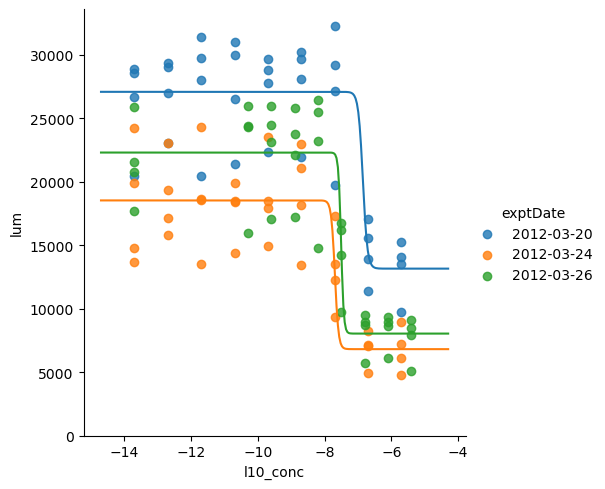

In [8]:
b = sns.lmplot(x='l10_conc', y='lum', data=p, hue='exptDate',fit_reg=False)
b.set(ylim=(0, None))
for fit in fitRawData:
    l = sns.lineplot(x=[i for i in myconc], y=[ll4(10**i,*[fit[i] for i in ['h','E0','Emax','EC50']]) for i in myconc], legend=False)

#### Perform nonlinear regression on data using `viability` model  
Use `resp_ratio` values. 

In [9]:
fitRatioData = []
for name, group in grouped:
    fitCoefs, covMatrix = opt.curve_fit(viability, group.conc, group.resp_ratio, p0=[1,0,1e-7])
    resids = group.resp_ratio-group.conc.apply(lambda x: viability(x,*fitCoefs))
    curFit = dict(zip(['b','d','e'],fitCoefs))
    curFit['exptDate']=name
    curFit['residuals']=sum(resids**2)
    fitRatioData.append(curFit)
    
fitRatioData

/Users/darren/mambaforge/envs/thunor/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[{'b': 9.932214528507181,
  'd': 0.5027940965735276,
  'e': 1.6032840652333832e-07,
  'exptDate': ('2012-03-20',),
  'residuals': 0.6157521513304051},
 {'b': 8.705902587166822,
  'd': 0.3751032488777039,
  'e': 2.0499371977561664e-08,
  'exptDate': ('2012-03-24',),
  'residuals': 0.9761750322879313},
 {'b': 12.019216174717531,
  'd': 0.3741380237108558,
  'e': 3.159539376494542e-08,
  'exptDate': ('2012-03-26',),
  'residuals': 0.7381374312834178}]

#### Plot the data and predicted model fits using Seaborn

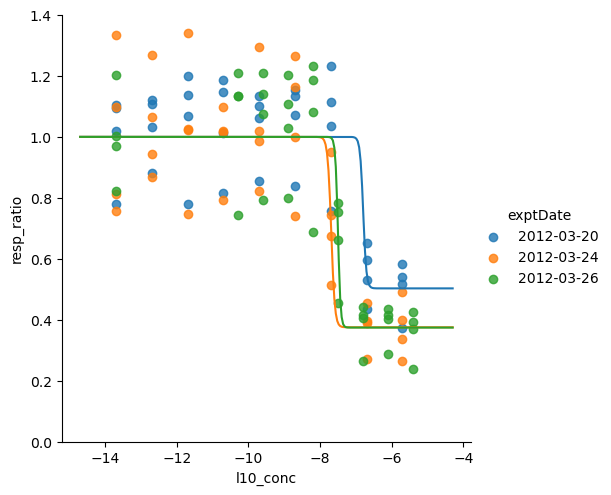

In [10]:
a = sns.lmplot(x='l10_conc', y='resp_ratio', data=p, hue='exptDate',fit_reg=False)
a.set(ylim=(0, 1.4))
for fit in fitRatioData:
    l = sns.lineplot(x=[i for i in myconc], y=[viability(10**i,*[fit[i] for i in ['b','d','e']]) for i in myconc], legend=False)

In [11]:
m = p[["l10_conc","resp_ratio"]].groupby(['l10_conc']).agg(['mean', 'std'])
m = m.xs('resp_ratio', axis=1, drop_level=True)
m.reset_index(inplace=True)
m['conc'] = 10**m['l10_conc']
m

l10_conc      mean       std          conc
0    -13.699  1.000000  0.180392  1.999862e-14
1    -12.699  1.036115  0.134687  1.999862e-13
2    -11.699  1.039790  0.199748  1.999862e-12
3    -10.699  1.010883  0.142711  1.999862e-11
4    -10.291  1.054499  0.210896  5.116818e-11
5     -9.699  1.034374  0.152811  1.999862e-10
6     -9.592  1.055267  0.182893  2.558586e-10
7     -8.893  1.034929  0.171832  1.279381e-09
8     -8.699  1.046473  0.177480  1.999862e-09
9     -8.194  1.046552  0.247222  6.397348e-09
10    -7.699  0.878108  0.245007  1.999862e-08
11    -7.495  0.663184  0.148731  3.198895e-08
12    -6.796  0.382310  0.079525  1.599558e-07
13    -6.699  0.465101  0.122453  1.999862e-07
14    -6.097  0.384171  0.066726  7.998343e-07
15    -5.699  0.437686  0.111417  1.999862e-06
16    -5.398  0.355933  0.081800  3.999447e-06

#### Fit ll4 model to resp_ratio means


In [12]:
fitCoefs, covMatrix = opt.curve_fit(viability, m['conc'], m['mean'], p0=[1,0,1e-7])

#### Plot the data and predicted curve

<Axes: xlabel='l10_conc', ylabel='mean'>

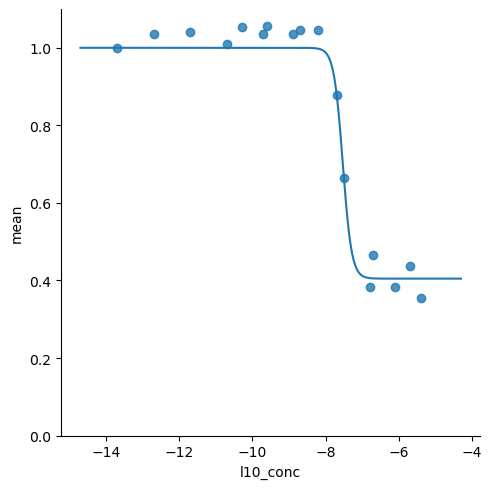

In [13]:
a = sns.lmplot(x='l10_conc', y='mean', data=m, fit_reg=False)
a.set(ylim=(0, 1.1))
sns.lineplot(x=[i for i in myconc], y=[viability(10**i,*fitCoefs) for i in myconc], legend=False)

In [14]:
fitCoefs

array([3.57228489e+00, 4.04706662e-01, 2.95996687e-08])